#### 시계열 예측 진행

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import scipy
import networkx as nx
import folium
from urllib.parse import unquote

import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [2]:
#tensorflow's keras 학습
#https://www.tensorflow.org/guide/keras/train_and_evaluate?hl=ko&_gl=1*us1bn2*_up*MQ..*_ga*MTAyMzk2OTc5MS4xNzExNjkxMTA0*_ga_W0YLR4190T*MTcxMTY5ODEyMi4yLjAuMTcxMTY5ODEyMi4wLjAuMA..

In [3]:
df = pd.read_csv('learningdata/testdata_202301.csv',encoding='utf-8')
df.head(5)

,일시,호선,역번호,역명,주말,요일,통과호선수,인구수,미세먼지(pm10),시간,하차인원,공휴일여부,강수량(mm),최저기온,최고기온
0,2023-01-01,1,150,서울역,1,0.62349,4,64714,54.0,5,154,1,0.0,-4.3,3.8
1,2023-01-01,1,151,시청,1,0.62349,2,64714,54.0,5,64,1,0.0,-4.3,3.8
2,2023-01-01,1,152,종각,1,0.62349,1,72067,53.0,5,69,1,0.0,-4.3,3.8
3,2023-01-01,1,153,종로3가,1,0.62349,3,72067,53.0,5,39,1,0.0,-4.3,3.8
4,2023-01-01,1,154,종로5가,1,0.62349,1,72067,53.0,5,26,1,0.0,-4.3,3.8


In [4]:
def timeCos(x): # 시간대 코사인 변환(24시와 5시의 시간적 차이를 줄이기 위해서)
    return np.cos(int(x) * np.pi / 12.0)
df['시간'] = df['시간'].apply(timeCos)

# 일시를 월+일로 시간을 cos함수로 변환 -> day_of_yer_cos에 저장
df['일시'] = pd.to_datetime(df['일시'])
df['day_of_year'] = df['일시'].dt.dayofyear
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

In [5]:
df = df.drop(['일시','day_of_year','역명'],axis=1)

In [6]:
df[['하차인원','강수량(mm)','최저기온','최고기온','시간','day_of_year_cos']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
하차인원,168640.0,692.967007,1046.384799,0.000000,179.000000,399.000000,799.000000,19027.000000
강수량(mm),168640.0,1.545161,6.591649,0.000000,0.000000,0.000000,0.000000,37.300000
최저기온,168640.0,-5.693548,4.699975,-17.300000,-8.000000,-5.600000,-3.500000,5.100000
최고기온,168640.0,3.196774,4.521466,-6.900000,-0.400000,3.800000,6.300000,12.500000
시간,168640.0,-0.151953,0.674731,-1.000000,-0.746836,-0.258819,0.319114,1.000000
day_of_year_cos,168640.0,0.950943,0.042794,0.860961,0.915864,0.962309,0.990532,0.999852


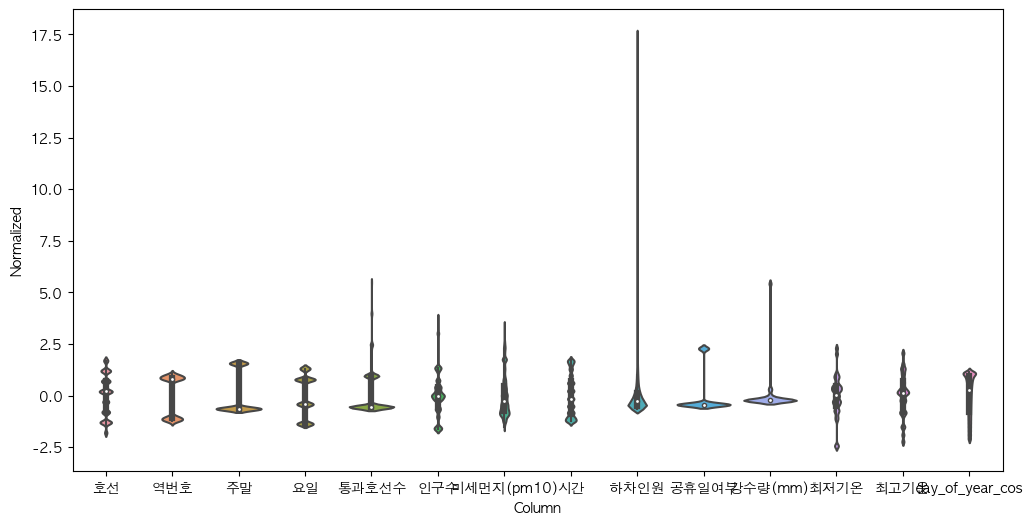

In [7]:
train_mean = df.mean()
train_std = df.std()
train_df = (df - train_mean) / train_std
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

plt.rcParams['font.family'] ='AppleGothic'
plt.rcParams['axes.unicode_minus'] =False

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=0)

In [8]:
X = df.drop('하차인원', axis=1)
y = df['하차인원']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [32]:
X_train.shape

(134912, 13)

In [38]:
# 모델 파이프라인 정의
model = keras.Sequential([
    layers.Input((13,1)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
]) 

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [39]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 7)

#with tf.device('/GPU:0'):
history = model.fit(X_train, y_train, batch_size=50, epochs=100, validation_split=0.2, callbacks = [early_stopping])

Epoch 1/100


2159/2159 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2323326.5000 - mae: 713.2077 - val_loss: 1139474.0000 - val_mae: 582.5666
Epoch 2/100
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1137277.5000 - mae: 584.5540 - val_loss: 1129394.3750 - val_mae: 587.4689
Epoch 3/100
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1157038.2500 - mae: 584.6550 - val_loss: 1138040.0000 - val_mae: 571.0237
Epoch 4/100
2149/2159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1115507.8750 - mae: 576.5967

KeyboardInterrupt: 

In [27]:
model.evaluate(X_test,y_test)

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - loss: 1052899.8750 - mae: 522.8383


[1005932.5, 513.242431640625]

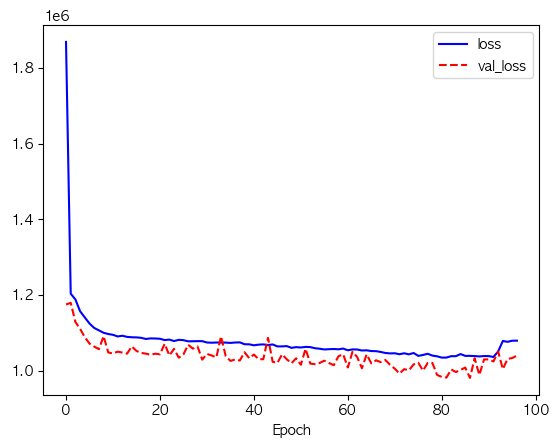

"\nfig, ax1 = plt.subplots()\n\ncolor = 'tab:red'\nax1.set_xlabel('Epoch')\nax1.set_ylabel('Loss', color=color)\nax1.plot(history.history['loss'], color=color, label='train')\nax1.plot(history.history['val_loss'], linestyle='--', color=color, label='val')\nax1.tick_params(axis='y', labelcolor=color)\n\nax2 = ax1.twinx()\n\ncolor = 'tab:blue'\nax2.set_ylabel('Accuracy', color=color)\nax2.plot(history.history['acc'], color=color, label='train')\nax2.plot(history.history['val_acc'], linestyle='--', color=color, label='val')\nax2.tick_params(axis='y', labelcolor=color)\n\n# 그래프에 legend 추가\nlines1, labels1 = ax1.get_legend_handles_labels()\nlines2, labels2 = ax2.get_legend_handles_labels()\nlines = lines1 + lines2\nlabels = labels1 + labels2\nax1.legend(lines, labels, loc='lower right')\n\nfig.tight_layout()\nplt.show()\n"

In [28]:
# 회귀 모델 학습 결과 시각화
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

'''
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(history.history['loss'], color=color, label='train')
ax1.plot(history.history['val_loss'], linestyle='--', color=color, label='val')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(history.history['acc'], color=color, label='train')
ax2.plot(history.history['val_acc'], linestyle='--', color=color, label='val')
ax2.tick_params(axis='y', labelcolor=color)

# 그래프에 legend 추가
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='lower right')

fig.tight_layout()
plt.show()
'''